In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [107]:
## Invent a dataset
nx = 5
x  = np.arange(nx)
y  = np.array([0.5,0.9,1.7,3.3,2])
ye = np.array([0.1,0.3,0.1,0.3,2])
ye = np.array([0.6,0.6,0.6,0.6,2])


df = pd.DataFrame({'x':x,'y':y,'ye':ye})

# Construct design matrix
X = sm.add_constant(x)

def cov2se(cov):
    return np.sqrt( np.diag(cov) )


In [109]:
# OLS
fitols = smf.ols('y ~ 1 + x',data=df).fit()
# WLS
fitwls = smf.wls('y ~ 1 + x',data=df,weights=1/ye**2).fit()

# Analytical OLS
# The Moore-Penrose pseudo-inverse Xpinv = (X.T @ X )**-1 @ X.T
Xpinv = np.linalg.pinv(X)
b  = Xpinv @ y
# Two equivalent ways of computing the parameter covariances
bcov = np.var(fitols.resid,ddof=2) * np.linalg.inv(X.T @ X )
bcov = Xpinv @ (np.var(fitols.resid,ddof=2) * np.eye(nx) ) @ Xpinv.T
# Instead of using the residuals to extimate the noise covariance, use independent information 
bcov2= Xpinv @ np.diag(ye**2) @ Xpinv.T
# parameter standard error
bse = cov2se( bcov )
bse2= cov2se( bcov2)


# Analytical WLS
W = np.diag(1/ye**2) / np.sum(1/ye**2)
bwls = np.linalg.inv(X.T @ W @ X )@ X.T @ W @ y 

# Equivalent
Xw = np.sqrt(W) @ X
yw = np.sqrt(W) @ y
Xwpinv = np.linalg.pinv(Xw)
bwls = Xwpinv @ yw

bcovwls = np.sum( W @ fitwls.resid**2) / (nx-2) * np.linalg.inv(Xw.T @ Xw)
bsewls = cov2se( bcovwls )

# Confirm that results are same as OLS
print(fitols.params)
print(fitols.bse)
print(bse)
print(bse2)

print(fitwls.params)
print(fitwls.bse)
print(bsewls)


Intercept    0.60
x            0.54
dtype: float64
Intercept    0.601997
x            0.245764
dtype: float64
[0.60199668 0.24576411]
[0.60133186 0.42614552]
Intercept    0.29533
x            0.84467
dtype: float64
Intercept    0.385145
x            0.198227
dtype: float64
[0.38514458 0.19822654]


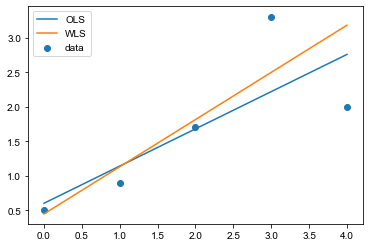

PARAMETERS
Intercept    0.60
x            0.54
dtype: float64
[0.60316503 0.53858571]
[0.6034374  0.53658175]

UNCERTAINTY

OLS
Intercept    0.601997
x            0.245764
dtype: float64

OLS + Bootstrap
[0.42147252 0.40261013]

WLS
Intercept    0.174821
x            0.114890
dtype: float64


In [96]:
# Bootstrap
n=30000
coef = np.zeros((2,n))
for i in range(n):
    # Add gaussian noise
    y2 = y + ye * np.random.randn(5)
    # fit the new data
    fit = sm.OLS(y2,X).fit()
    coef[:,i] = fit.params
    

plt.clf()
plt.scatter(x,y,label='data')
plt.plot(x,fitols.fittedvalues,label='OLS')
plt.plot(x,fitwls.fittedvalues,label='WLS')
plt.legend()
plt.show()

## 
print('PARAMETERS')
print(fitols.params)
print(np.median(coef,axis=1))
print(np.mean(coef,axis=1))

print('\nUNCERTAINTY')
print('\nOLS')
print(fitols.bse)
print('\nOLS + Bootstrap')
print(np.std(coef,axis=1))
print('\nWLS')
print(fitwls.bse)